# 05. Timebanks: Modeling
> Author: [Dawn Graham](https://dawngraham.github.io/)

Results from modeling are in the [Modeling Results notebook](./06_tb_modeling_results.ipynb).

Follow instructions below to recreate a model. Steps are also included at appropriate places in the notebook.

**Step 1:**
- Replace `features` with list under **Features** in [Modeling Results notebook](./06_tb_modeling_results.ipynb).

**Step 2:**
- For a model for ALL timebanks, set:
    - `X = data[features]`
    - `y = data['avg_daily_exchanges']`
- For a model for ACTIVE timebanks only, set:
    - `X = data_active[features]`
    - `y = data_active['avg_daily_exchanges']`
    
**Step 3:**
- Set appropriate model equal to value under **Selected model** in [Modeling Results notebook](./06_tb_modeling_results.ipynb).

**Step 4:**
- For the first value in `choose_model`, enter the selected model: `lr`, `ridge`, `lasso`, `enet`, or `tree`
- For the second value, enter `'ALL'` for a model for all timebanks or `'ACTIVE'` for a model for active timebanks only.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

import warnings
warnings.simplefilter(action='ignore')

from scipy import stats
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV,  ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from time import localtime, strftime

from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
import pydotplus

from IPython.display import display, Markdown, Latex, Image

%matplotlib inline

## Functions

In [2]:
def choose_model(choice, all_or_active):
    
    # Fit model
    model = choice.fit(X_train_sc, y_train)

    # Score the model
    training_score = model.score(X_train_sc, y_train)
    testing_score = model.score(X_test_sc, y_test)

    # Get residuals of predictions
    pred = model.predict(X_test_sc)
    residuals = y_test - pred

    # Print model info
    time = strftime("%y%m%d_%H%M%S", localtime())
    print(f'### Model ID: {time} - {all_or_active} timebanks')
    print('#### Selected model  \n{}  \n'.format(model))
    print('#### Features  \n{}  \n'.format(list(X)))
    print('|Metric|Value|')
    print('|-----|-----|')
    print('|**Training R2**|{:0.5f}|'.format(training_score))
    print('|**Testing R2**|{:0.5f}|'.format(testing_score))
    print('|**Explained variance**|{:0.5f}|'.format(explained_variance_score(y_test, pred)))
    print('|**Mean absolute error (MAE)**|{:0.5f}|'.format(mean_absolute_error(y_test, pred)))
    print('|**Mean squared error (MSE)**|{:0.5f}|'.format(mean_squared_error(y_test, pred)))
    print('|**Root mean squared error (RMSE)**|{:0.5f}|'.format(np.sqrt(mean_squared_error(y_test, pred))))
    print('|**Median absolute error (MedAE)**|{:0.5f}|'.format(median_absolute_error(y_test, pred)))
    print('|**Mean distribution of residuals**|{:0.5f}|'.format(residuals.mean()))
    print('\n')
    print('<table><tr><td><img src="../images/dist_{}.png"></td><td><img src="../images/prob_{}.png"></td></tr></table>'.format(time, time))
    print('\n')
    print('---')

    # Create residual plots
    plt.figure(1, figsize=(6.5,4))
    plt.title('Distribution of Residuals')
    sns.distplot(residuals)
    plt.tight_layout()
    
#     ## Commented out so it will not save when re-run
#     plt.savefig('../images/dist_{}.png'.format(time));

    plt.figure(2, figsize=(6.5,4))
    stats.probplot(residuals, plot=pylab)
    
#     ## Commented out so it will not save when re-run
#     plt.savefig('../images/prob_{}.png'.format(time));

## Read in data

In [3]:
df = pd.read_csv('../data/combined_2019-01-24_2019-02-07.csv')
df.head()

,timebank,sponsor,phone,url_2,facebook,twitter,mission_word_count,mission_sentiment,notes_word_count,notes_sentiment,...,facebook_likes,facebook_followers,twitter_tweets,twitter_following,twitter_followers,categories_total,categories_parent,categories_with_offers,categories_with_requests,talent_per_cat_per_member
0,addington,1.0,1.0,0.0,1.0,0.0,320.0,0.9986,144.0,0.8943,...,169.0,172.0,0.0,0.0,0.0,89.0,11.0,0.325843,0.146067,0.391840
1,aha,0.0,1.0,0.0,0.0,0.0,20.0,0.7717,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,alticultura,1.0,1.0,0.0,0.0,0.0,12.0,0.0000,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,18.0,11.0,0.000000,0.000000,0.318182
3,andersoncommunity,1.0,1.0,0.0,0.0,0.0,20.0,0.6369,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,ate,1.0,1.0,1.0,1.0,0.0,11.0,0.4215,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,18.0,9.0,0.277778,0.000000,0.138889


In [4]:
# Get only numerical columns
data = df.loc[:, df.columns != 'timebank']

In [5]:
# Get data for active timebanks only
data_active = data[data['avg_daily_exchanges'] != 0]

## Modeling

### Create features & target

In [6]:
data.columns

Index(['sponsor', 'phone', 'url_2', 'facebook', 'twitter',
       'mission_word_count', 'mission_sentiment', 'notes_word_count',
       'notes_sentiment', 'avg_daily_exchanges', 'avg_daily_hours',
       'hours_per_exchange', 'avg_offers', 'avg_requests',
       'offer_request_ratio', 'members_starting', 'members_daily_new',
       'facebook_likes', 'facebook_followers', 'twitter_tweets',
       'twitter_following', 'twitter_followers', 'categories_total',
       'categories_parent', 'categories_with_offers',
       'categories_with_requests', 'talent_per_cat_per_member'],
      dtype='object')

**Step 1:** Replace `features` with list under **Features** in [Modeling Results notebook](./06_tb_modeling_results.ipynb).  
**Step 2:**
- For a model for ALL timebanks, set:
    - `X = data[features]`
    - `y = data['avg_daily_exchanges']`
- For a model for ACTIVE timebanks only, set:
    - `X = data_active[features]`
    - `y = data_active['avg_daily_exchanges']`

In [7]:
features = ['phone', 'facebook', 'mission_sentiment', 'notes_word_count', 'hours_per_exchange',
            'avg_offers', 'avg_requests', 'offer_request_ratio', 'categories_with_requests']

X = data[features]
X = sm.add_constant(X)
y = data['avg_daily_exchanges']

### Train/test split, scale, and get cross-val scores

In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Select all non-dummy columns to scale
non_dummy = ['mission_word_count', 'mission_sentiment', 'notes_word_count', 'notes_sentiment',
             'avg_daily_exchanges', 'avg_daily_hours', 'hours_per_exchange', 'avg_offers', 'avg_requests', 
             'offer_request_ratio', 'members_starting', 'members_daily_new', 'facebook_likes',
             'facebook_followers', 'twitter_tweets', 'twitter_following', 'twitter_followers',
             'categories_total', 'categories_parent', 'categories_with_offers', 'categories_with_requests',
             'talent_per_cat_per_member']
col_names = [col for col in non_dummy if col in features]

# Scale X_train
X_train_sc = X_train.copy()
features_sc = X_train_sc[col_names].astype(float)
ss = StandardScaler()
ss.fit(features_sc.values)
features_sc = ss.transform(features_sc.values)
X_train_sc[col_names] = features_sc

# Scale X_test
X_test_sc = X_test.copy()
features_sc = X_test_sc[col_names].astype(float)
features_sc = ss.transform(features_sc.values)
X_test_sc[col_names] = features_sc

# Instantiate models
lr = LinearRegression()
lasso = LassoCV(random_state=42)
ridge = RidgeCV()
enet = ElasticNetCV(random_state=42)
tree = DecisionTreeRegressor(random_state=42)

# Get cross val scores
lr_score = cross_val_score(lr, X_train_sc, y_train, cv=3).mean()
ridge_score = cross_val_score(ridge, X_train_sc, y_train, cv=3).mean()
lasso_score = cross_val_score(lasso, X_train_sc, y_train, cv=3).mean()
enet_score = cross_val_score(enet, X_train_sc, y_train, cv=3).mean()
tree_score = cross_val_score(tree, X_train_sc, y_train, cv=3).mean()

# Print cross validation scores
print('Linear: {:0.5f}'.format(lr_score))
print('Ridge: {:0.5f}'.format(ridge_score))
print('Lasso: {:0.5f}'.format(lasso_score))
print('Elastic net: {:0.5f}'.format(enet_score))
print('Decision tree: {:0.5f}'.format(tree_score))

Linear: -90.16127
Ridge: 0.14663
Lasso: 0.17943
Elastic net: 0.18952
Decision tree: -2.66172


In [9]:
# Gridsearch to get best params
tree_params = {
    'splitter': ['best', 'random'],
    'max_depth': [3, 4, 5, None],
    'min_samples_split': [2, 3, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [14, 15, 16, None],
}
gs = GridSearchCV(tree, param_grid=tree_params)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

0.19529563894277668


{'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': 15,
 'min_samples_split': 2,
 'splitter': 'random'}

**Step 3:** Set appropriate model equal to value under **Selected model** in [Modeling Results notebook](./06_tb_modeling_results.ipynb).

In [10]:
lr = LinearRegression()

lasso = LassoCV(alphas=None, max_iter=86, n_alphas=5, random_state=42)

tree = DecisionTreeRegressor(max_depth=4, max_features='auto', max_leaf_nodes=15,
                             min_samples_split=2, splitter='random', random_state=42)

**Step 4:**
- For the first value in `choose_model`, enter the selected model: `lr`, `ridge`, `lasso`, `enet`, or `tree`
- For the second value, enter `'ALL'` for a model for all timebanks or `'ACTIVE'` for a model for active timebanks only.

### Model ID: 190210_211720 - ALL timebanks
#### Selected model  
DecisionTreeRegressor(criterion='mse', max_depth=4, max_features='auto',
           max_leaf_nodes=15, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='random')  

#### Features  
['const', 'phone', 'facebook', 'mission_sentiment', 'notes_word_count', 'hours_per_exchange', 'avg_offers', 'avg_requests', 'offer_request_ratio', 'categories_with_requests']  

|Metric|Value|
|-----|-----|
|**Training R2**|0.86770|
|**Testing R2**|0.28028|
|**Explained variance**|0.29172|
|**Mean absolute error (MAE)**|0.52129|
|**Mean squared error (MSE)**|1.15532|
|**Root mean squared error (RMSE)**|1.07486|
|**Median absolute error (MedAE)**|0.20301|
|**Mean distribution of residuals**|0.13554|


<table><tr><td><img src="../images/dist_190210_211720.png"></td><td><img src="../images/prob_190210

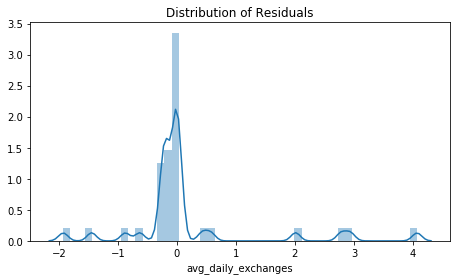

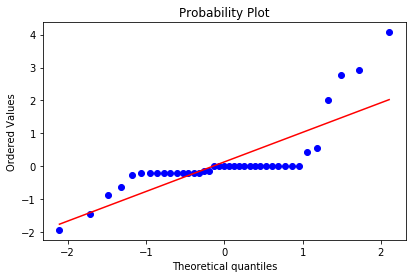

In [11]:
choose_model(tree, 'ALL')

### Get coefficients for linear, lasso, ridge, or elastice net models

In [12]:
# # Get model coefficients 
# coefs = list(zip(X_train.columns, lr.coef_))
# pd.DataFrame(coefs, columns=['Feature','Coef']).sort_values(by='Coef', ascending=False)

### Decision Tree Visualization

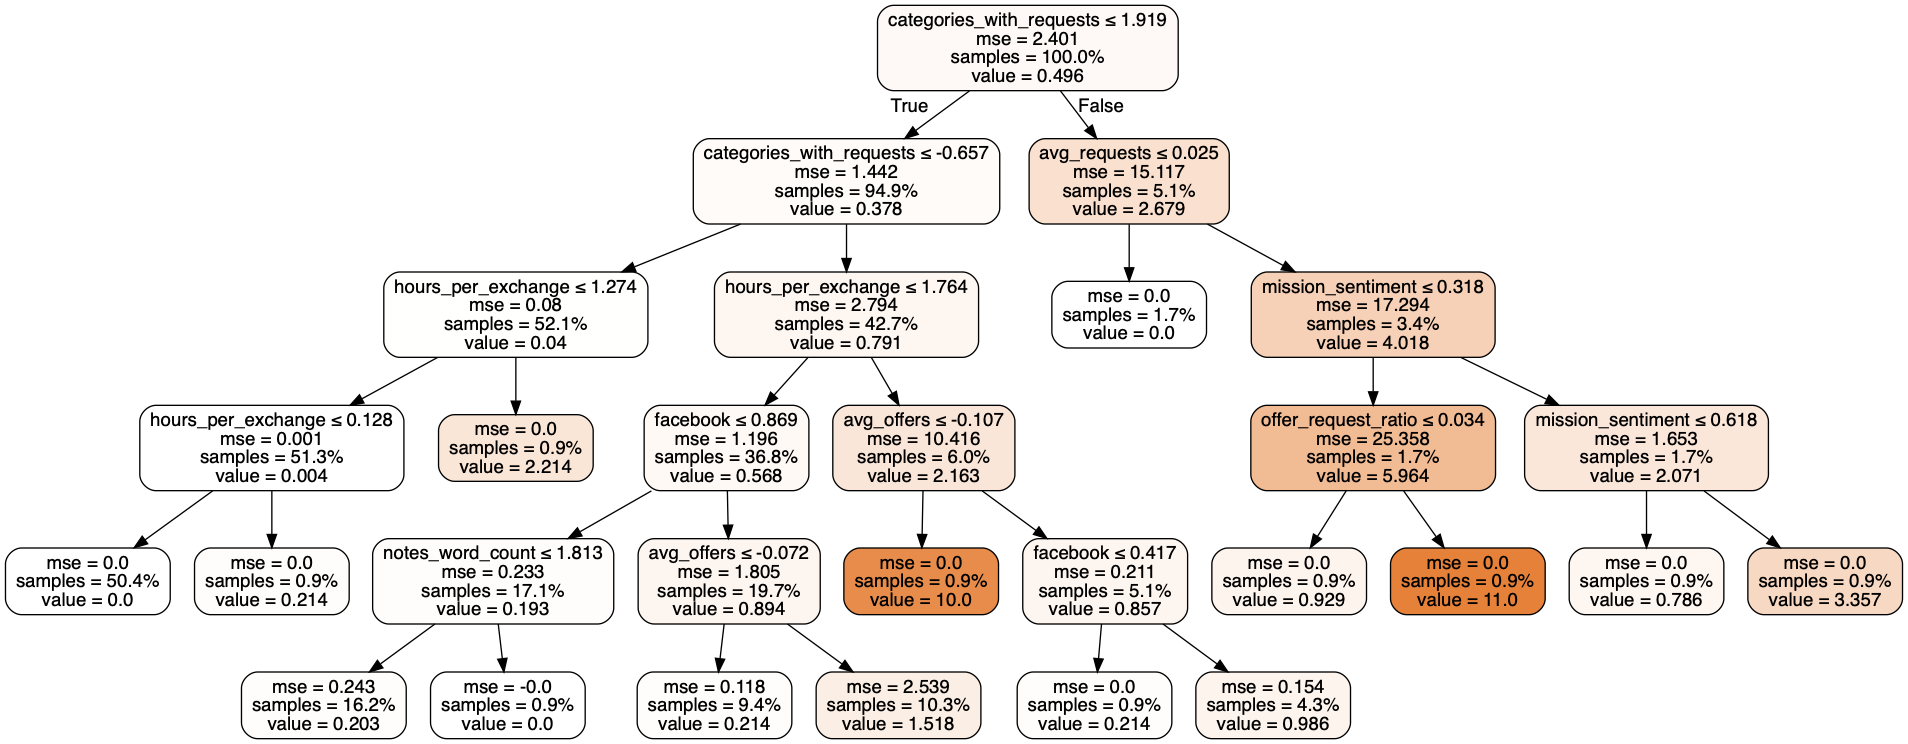

In [13]:
dot_data = StringIO()  

export_graphviz(
    tree, 
    out_file = dot_data,  
    filled=True, rounded=True, proportion=True,  # Set `proportion=False` to see number of records instead
    special_characters=True, 
    feature_names=X_train_sc.columns,
)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### OLS Model
This will return results equivalent to the selected `LinearRegression()` model, but with additional information.

In [14]:
ols = sm.OLS(y_train, X_train_sc).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     avg_daily_exchanges   R-squared:                       0.404
Model:                             OLS   Adj. R-squared:                  0.354
Method:                  Least Squares   F-statistic:                     8.049
Date:                 Sun, 10 Feb 2019   Prob (F-statistic):           4.97e-09
Time:                         21:17:20   Log-Likelihood:                -187.00
No. Observations:                  117   AIC:                             394.0
Df Residuals:                      107   BIC:                             421.6
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.2056      0.902      0.228      0.820      -1.582       1.993
phone                        0.3609      0.903      0.400      0.690      -1.428       2.150
facebook                    -0.1782      0.290     -0.614      0.540      -0.753       0.397
mission_sentiment           -0.0175      0.124     -0.141      0.888      -0.263       0.228
notes_word_count            -0.2542      0.131     -1.947      0.054      -0.513       0.005
hours_per_exchange           0.6848      0.162      4.227      0.000       0.364       1.006
avg_offers                 -44.8278     10.850     -4.131      0.000     -66.337     -23.318
avg_requests                44.8111     10.856      4.128      0.000      23.291      66.331
offer_request_ratio          0.2453      0.168      1.459      0.147      -0.088       0.579
categories_with_requests     0.0785      0.169      0.464      0.644      -0.257       0.414
==============================================================================
Omnibus:                      139.928   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3494.507
Skew:                           4.232   Prob(JB):                         0.00
Kurtosis:                      28.401   Cond. No.                         205.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

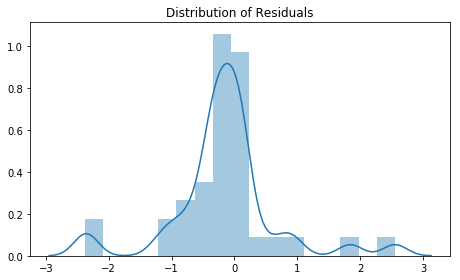

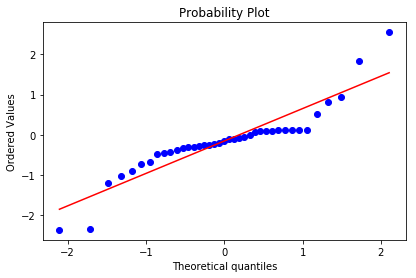

In [15]:
# Get residuals of predictions
pred = ols.predict(X_test_sc)
residuals = y_test - pred

# Create residual plots
plt.figure(1, figsize=(6.5,4))
plt.title('Distribution of Residuals')
sns.distplot(residuals)
plt.tight_layout()

plt.figure(2, figsize=(6.5,4))
stats.probplot(residuals, plot=pylab);

In [16]:
# Get RMSE
print(np.sqrt(mean_squared_error(y_test, pred)))

0.8566252456617897


In [17]:
# Summary of predictions
pred = ols.get_prediction(X_test_sc)
pred.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
96,0.750043,0.235908,0.282383,1.217703,-1.773823,3.273908
69,0.430364,0.256462,-0.078043,0.938771,-2.101368,2.962096
82,1.367887,0.290911,0.791190,1.944584,-1.178438,3.914212
76,-0.107995,0.232811,-0.569515,0.353525,-2.630730,2.414740
114,1.670424,0.270124,1.134934,2.205913,-0.866886,4.207733
29,-0.101147,0.206202,-0.509920,0.307625,-2.614767,2.412473
94,0.284320,0.310678,-0.331564,0.900203,-2.271165,2.839805
132,0.119014,0.259977,-0.396361,0.634389,-2.414127,2.652155
93,0.337012,0.221901,-0.102882,0.776905,-2.181857,2.855880
139,0.312253,0.207232,-0.098560,0.723066,-2.201700,2.826206
